# Predicting Net Interchange with ARIMA & Neural Network Models

* [Data Preparation](#data-preparation)
    * [Package Imports](#package-imports)
    * [Data Import](#data-import)
    * [Train and Test Data](#train-and-test-data)
* [ARIMA](#arima)
    * [Evaluating ARIMA Performance](#evaluating-arima-performance)
    * [Visualizing ARIMA Performance](#visualizing-arima-performance)
* [Neural Network](#neural-network)
    * [Train-Test Split](#train-test-split)
    * [Training Neural Network Model](#training-neural-network-model)
    * [Making Predictions with Neural Network Model](#making-predictions-with-neural-network-model)
    * [Evaluating Neural Network Performance](#evaluating-neural-network-performance)
    * [Visualizing Neural Network Performance](#visualizing-neural-network-performance)

## Data Preparation <a class="anchor" id="data-preparation"></a>

### Package Imports <a class="anchor" id="package-imports"></a>

In [1]:
from math import sqrt
import numpy as np
import pandas as pd


# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Models
from keras.layers import Dense
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

plt.style.use('seaborn-white')

### Data Import <a class="anchor" id="data-import"></a>

In [3]:
filename = 'wind_data.csv'
df = pd.read_csv(filename, usecols=["Date/Time", "NET INTERCHANGE (MW; SCADA 45581)"])

cols = ["date","net_interchange"]
df.columns = cols                        # Rename columns
df["date"] = pd.to_datetime(df["date"])  # Convert to datetime datatype
df = df.set_index("date")

df = df.resample("H").mean()             # Convert to hourly
df = df.dropna()                         # Drop null values

df.head()

,net_interchange
date,
2012-01-01 00:00:00,3895.833333
2012-01-01 01:00:00,3802.166667
2012-01-01 02:00:00,3792.416667
2012-01-01 03:00:00,3719.083333
2012-01-01 04:00:00,3683.500000


In [4]:
df.describe()

,net_interchange
count,8783.000000
mean,7378.965400
std,2483.852294
min,1345.166667
25%,5373.666667
50%,7611.416667
75%,9445.708333
max,12690.666667


### Train and Test Data <a class="anchor" id="train-and-test-data"></a>

In [5]:
X = df["net_interchange"].values
test_size = 24  # We will be forecasting 24 hours
perc_train = 1 - test_size/len(X)
train_size = int(len(X) * perc_train)
train, test = X[0:train_size], X[train_size:len(X)]

## ARIMA <a class="anchor" id="arima"></a>

In [6]:
p = 5  # The number of lag observations included in the model.
d = 1  # The number of times that the raw observations are differenced.
q = 0  # The size of the moving average window

history = [x for x in train]
predictions = []

for i in range(len(test)):
    model = ARIMA(history, order=(p, d, q))
    model_fit = model.fit()   # Training the Model
    output = model_fit.forecast()   # Making Prediction
    predicted = output[0]
    predictions.append(predicted)  
    actual = test[i]
    history.append(actual)
    difference = actual - predicted
    print('predicted=%f, actual=%f, difference=%f' % (predicted, actual, difference))

predicted=5581.604174, actual=5434.583333, difference=-147.020840
predicted=5371.154774, actual=5537.666667, difference=166.511892
predicted=5678.744867, actual=5202.000000, difference=-476.744867
predicted=5228.558390, actual=5279.916667, difference=51.358277
predicted=5350.727065, actual=5637.666667, difference=286.939602
predicted=5829.105677, actual=6374.500000, difference=545.394323
predicted=6704.464531, actual=8040.250000, difference=1335.785469
predicted=8819.906985, actual=8375.916667, difference=-443.990318
predicted=8559.742774, actual=8643.500000, difference=83.757226
predicted=8689.015024, actual=8530.666667, difference=-158.348357
predicted=8351.180359, actual=8015.083333, difference=-336.097025
predicted=7584.970089, actual=7919.416667, difference=334.446577
predicted=7811.489630, actual=7901.666667, difference=90.177036
predicted=7869.310984, actual=7956.000000, difference=86.689016
predicted=8009.540686, actual=7864.583333, difference=-144.957353
predicted=7889.252099,

### Evaluating ARIMA Performance <a class="anchor" id="evaluating-arima-performance"></a>

In [18]:
rmse = sqrt(mean_squared_error(test, predictions))
print('Test Score: %.2f RMSE' % rmse)

results_df = pd.DataFrame(zip(df.index[train_size:], test), columns=["date", "actual"])
results_df["predicted"] = predictions
results_df["difference"] = results_df["actual"] - results_df["predicted"]
results_df = results_df.set_index("date")
results_df.head()

ValueError: Found input variables with inconsistent numbers of samples: [24, 23]

In [8]:
results_df.describe()

,actual,predicted,difference
count,24.000000,24.000000,24.000000
mean,7347.729167,7358.893537,-11.164370
std,1335.018256,1374.376405,548.719225
min,5202.000000,5069.218894,-1662.615807
25%,5796.604167,5791.515475,-190.119931
50%,7907.625000,7797.760052,19.250042
75%,8414.604167,8534.983340,213.140310
max,8905.083333,9069.567681,1335.785469


### Visualizing ARIMA Performance <a class="anchor" id="visualizing-arima-performance"></a>

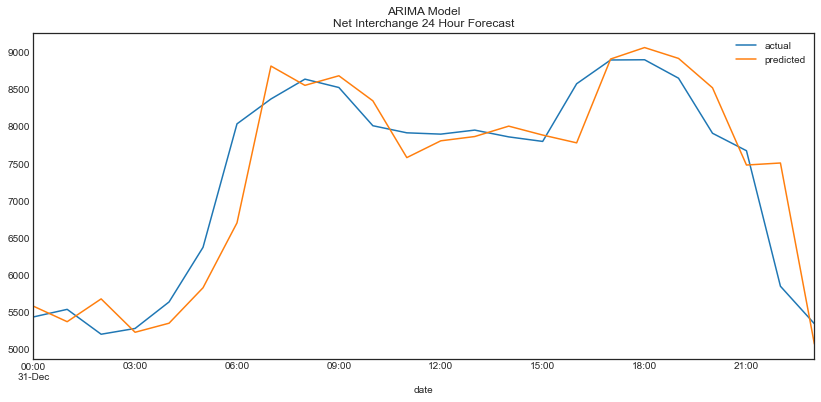

In [9]:
results_df[["actual", "predicted"]].plot(title="ARIMA Model\nNet Interchange 24 Hour Forecast", figsize=(14,6))
plt.show()

## Neural Network <a class="anchor" id="neural-network"></a>

### Train-Test Split <a class="anchor" id="train-test-split"></a>

In [10]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d])
        Y.append(data_arr[d])
    return np.array(X), np.array(Y)

In [11]:
lookback = 1
train_X, train_Y = convert2matrix(train, lookback)
test_X, test_Y = convert2matrix(test, lookback)

### Training Neural Network Model <a class="anchor" id="training-neural-network-model"></a>

In [12]:
model = Sequential()
model.add(Dense(32, input_dim=lookback, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mse'])
model.fit(train_X, train_Y, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
8758/8758 - 6s - loss: 498956.5000 - mse: 498956.5000
Epoch 2/10
8758/8758 - 6s - loss: 244717.7969 - mse: 244717.7969
Epoch 3/10
8758/8758 - 5s - loss: 243766.2969 - mse: 243766.2969
Epoch 4/10
8758/8758 - 6s - loss: 244117.7344 - mse: 244117.7344
Epoch 5/10
8758/8758 - 6s - loss: 244246.5469 - mse: 244246.5469
Epoch 6/10
8758/8758 - 6s - loss: 244794.3750 - mse: 244794.3750
Epoch 7/10
8758/8758 - 7s - loss: 243259.4375 - mse: 243259.4375
Epoch 8/10
8758/8758 - 6s - loss: 243578.0469 - mse: 243578.0469
Epoch 9/10
8758/8758 - 6s - loss: 243184.5938 - mse: 243184.5938
Epoch 10/10
8758/8758 - 6s - loss: 243400.3125 - mse: 243400.3125


### Making Predictions with Neural Network Model <a class="anchor" id="making-predictions-with-neural-network-model"></a>

In [17]:
predictions = model.predict(test_X) # Make predictions
rmse = sqrt(mean_squared_error(test_Y, predictions))
print('Test Score: %.2f RMSE' % rmse)

Test Score: 644.49 RMSE


### Evaluating Neural Network Performance <a class="anchor" id="evaluating-neural-network-performance"></a>

In [14]:
results_df = pd.DataFrame(zip(df.index[train_size+1:], test), columns=["date", "actual"])
results_df["predicted"] = predictions
results_df["difference"] = results_df["actual"] - results_df["predicted"]
results_df = results_df.set_index("date")
results_df.head()

,actual,predicted,difference
date,,,
2012-12-31 01:00:00,5434.583333,5305.875977,128.707357
2012-12-31 02:00:00,5537.666667,5406.300293,131.366374
2012-12-31 03:00:00,5202.000000,5079.292480,122.707520
2012-12-31 04:00:00,5279.916667,5155.199219,124.717448
2012-12-31 05:00:00,5637.666667,5503.720215,133.946452


In [15]:
results_df.describe()

,actual,predicted,difference
count,23.000000,23.000000,23.000000
mean,7434.873188,7254.564453,180.307971
std,1293.345972,1259.982056,33.363936
min,5202.000000,5079.292480,122.707520
25%,6112.041667,5965.858154,146.183512
50%,7913.583333,7720.926758,192.656576
75%,8453.291667,8246.712158,206.579508
max,8905.083333,8686.848633,218.234701


### Visualizing Neural Network Performance <a class="anchor" id="visualizing-neural-network-performance"></a>

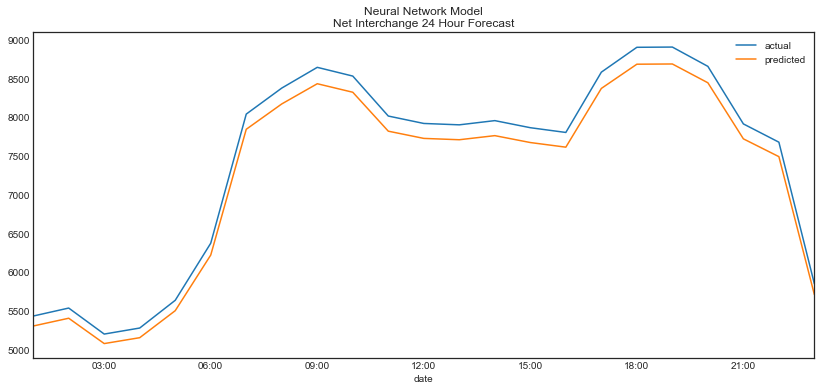

In [16]:
results_df[["actual", "predicted"]].plot(title="Neural Network Model\nNet Interchange 24 Hour Forecast", figsize=(14,6))
plt.show()